# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
data.head()


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [2]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

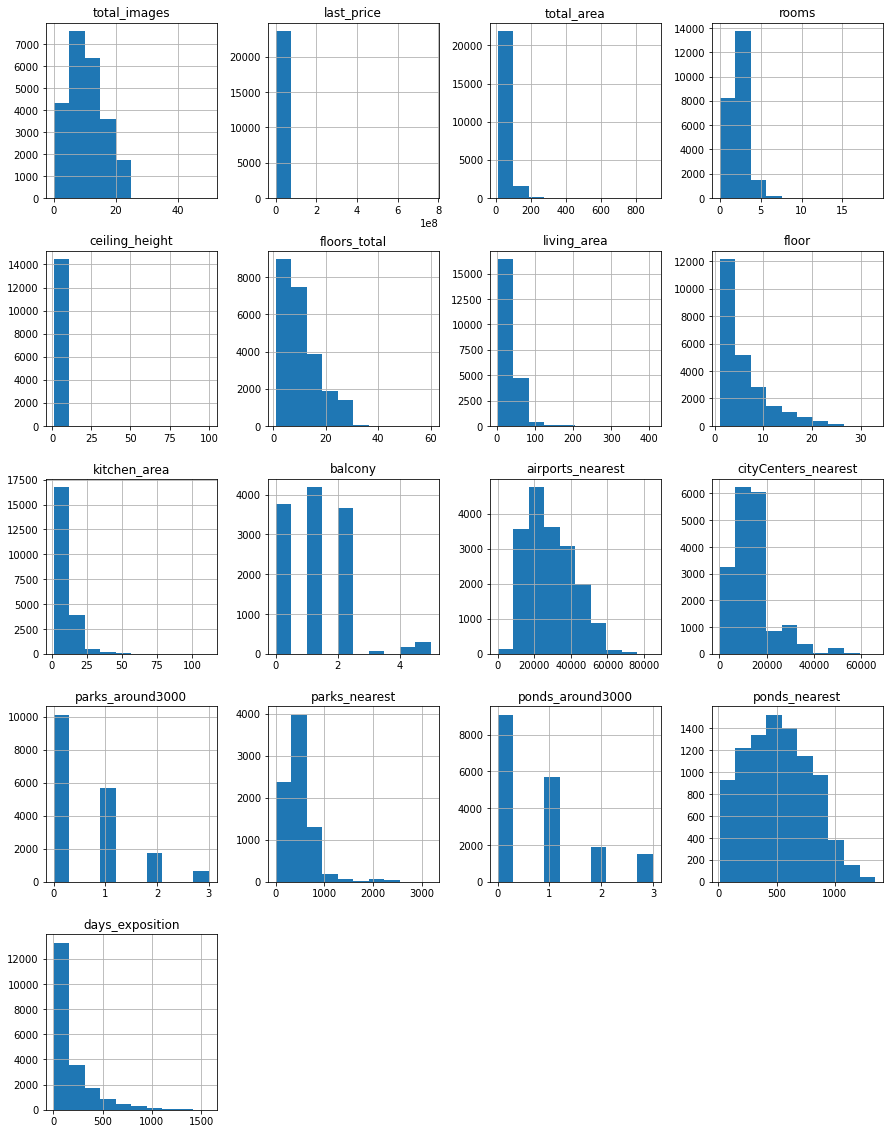

In [3]:
data.hist(figsize=(15, 20));

В 1 пункте были загружены  данные, и изучена общая информация о датафрейме а именно: вывод датафрейма, информация о столбцах и показательные гистограммы для всех числовых столбцов таблицы.

### Предобработка данных

In [4]:
# приведем столбцы к змеиному синтаксису
data.rename(columns={'cityCenters_nearest' : 'city_centers_nearest'}, inplace=True)
data.rename(columns={'parks_around3000' : 'parks_around_3000'}, inplace=True)
data.rename(columns={'ponds_around3000' : 'ponds_around_3000'}, inplace=True)

1.Пропущенные значения

In [5]:
# Найдем количество пропущенных значений и определим сколько процентов пропуски состовляют от общего количества данных в столбце:
def miss_values(data):
    miss_count = data.isna().sum()
    miss_percent = round(data.isna().sum() * 100 / len(data), 2)
    
    miss_data = pd.DataFrame({'name': data.columns,
                              'kol_miss': miss_count,
                              'perc_miss': miss_percent})
    
    return miss_data
miss_values(data)


,name,kol_miss,perc_miss
total_images,total_images,0,0.00
last_price,last_price,0,0.00
total_area,total_area,0,0.00
first_day_exposition,first_day_exposition,0,0.00
rooms,rooms,0,0.00
ceiling_height,ceiling_height,9195,38.80
floors_total,floors_total,86,0.36
living_area,living_area,1903,8.03
floor,floor,0,0.00
is_apartment,is_apartment,20924,88.29


Количество пропусков из общего количества:
- ceiling_height: 9195 пропусков, а это 38%. Оставим значение Null в столбце с высотой потолков.
- floors_total: данные не ввели оставляем Null.
- living_area: данные не ввели оставляем Null.
- is_apartment: скорее всего так обозначаются не апартаменты, поставим значение False.
- kitchen_area: данные не ввели оставляем Null.
- balcony: скорее всего там нет балконов, поставим значение 0.
- locality_name: данные не ввели оставляем Null.
- airports_nearest: аэропортов  нет, оставляем Null.
- city_centers_nearest: центр далеко оставляем Null.
- parks_around_3000: парков нет в радиусе 3км, поставим значение 0.
- parks_nearest: парков нет, оставляем Null.
- ponds_around_3000: прудов нет в радиусе 3км, поставим значение 0.
- ponds_nearest: прудов нет, оставляем Null.
- days_exposition: данные не ввели оставляем Null.




In [6]:
# изменим нужные Null значения
data['is_apartment'] = data['is_apartment'].fillna('False')
data['balcony'] = data['balcony'].fillna(0).astype(int)
data['parks_around_3000'] = data['parks_around_3000'].fillna(value=0).astype(int)
data['ponds_around_3000'] = data['ponds_around_3000'].fillna(value=0).astype(int)

In [7]:
# код ревьюера

bool('False')

True

In [8]:
# Заменяем оставшиеся пустые значения высоты потолков на медианное значение по всему датасету
data['ceiling_height'].fillna(data['ceiling_height'].median(), inplace=True)

# Заменяем оставшиеся пустые значения жилой площади и площади кухни
living_ratio = data['living_area'].mean() / data['total_area'].mean()
kitchen_ratio = data['kitchen_area'].mean() / data['total_area'].mean()
data['living_area'].fillna(living_ratio * data['total_area'], inplace=True)
data['kitchen_area'].fillna(kitchen_ratio * data['total_area'], inplace=True)

# Удаляем записи, где отсутствует локация и этажность
data.dropna(subset=['locality_name'], inplace=True)
data.dropna(subset=['floors_total'], inplace=True)




In [9]:
data.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total                0
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         5524
city_centers_nearest     5501
parks_around_3000           0
parks_nearest           15535
ponds_around_3000           0
ponds_nearest           14529
days_exposition          3171
dtype: int64

2. Типы данных

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23565 non-null  int64  
 1   last_price            23565 non-null  float64
 2   total_area            23565 non-null  float64
 3   first_day_exposition  23565 non-null  object 
 4   rooms                 23565 non-null  int64  
 5   ceiling_height        23565 non-null  float64
 6   floors_total          23565 non-null  float64
 7   living_area           23565 non-null  float64
 8   floor                 23565 non-null  int64  
 9   is_apartment          23565 non-null  object 
 10  studio                23565 non-null  bool   
 11  open_plan             23565 non-null  bool   
 12  kitchen_area          23565 non-null  float64
 13  balcony               23565 non-null  int64  
 14  locality_name         23565 non-null  object 
 15  airports_nearest   

- Изменение типа first_day_exposition c object на date необходимо, чтобы работать с датой было удобно.
- В остальных случаях экономим памть

In [11]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data['floors_total'] =  data['floors_total'].astype('Int8')
data['last_price'] = data['last_price'].astype('int64')



In [12]:
data.info()


     

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  int64         
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        23565 non-null  float64       
 6   floors_total          23565 non-null  Int8          
 7   living_area           23565 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  object        
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          23565 non-null  float64       
 13  balcony         

3. Уникальные значения

In [13]:
def loc_length():
    return print('Количество уникальных значений:', data['locality_name'].unique().shape[0])
loc_length()


Количество уникальных значений: 364


Удаление дубликатов:
1. Перевод в нижний регистр.
2. Замена ё на е.
3. "городской поселок" --> "поселок городского типа"
4. наличие явнфх дубликатов

In [14]:
# нижний регистр
data['locality_name'] = data['locality_name'].str.lower()


In [15]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')
print('Заменяем все "ё" на "е"')
loc_length()
print()



Заменяем все "ё" на "е"
Количество уникальных значений: 330



In [16]:
data['locality_name'] = data['locality_name'].str.replace('городской поселок','поселок городского типа')
print('Заменяем "городской поселок" на "поселок городского типа"')
loc_length()
print()

Заменяем "городской поселок" на "поселок городского типа"
Количество уникальных значений: 323



In [17]:
# кол-во явных дубликато
print('Количество явных дубликатов:', data.duplicated().sum())



Количество явных дубликатов: 0


Аномальные значения

In [18]:
# оценим распределение
data.describe()




,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition
count,23565.000000,2.356500e+04,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,23565.000000,18041.000000,18064.000000,23565.000000,8030.000000,23565.000000,9036.000000,20394.000000
mean,9.878421,6.540058e+06,60.322824,2.070656,2.724530,10.675875,34.591303,5.878124,10.500277,0.593677,28797.082701,14192.656056,0.468831,490.580448,0.589900,518.289509,180.741395
std,5.681156,1.091093e+07,35.657060,1.078591,0.991026,6.594823,22.372806,4.871485,6.038042,0.960660,12632.499735,8613.348153,0.748403,341.572956,0.883966,278.009558,219.732782
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,19.000000,2.000000,7.000000,0.000000,18565.000000,9238.000000,0.000000,288.000000,0.000000,293.000000,45.000000
50%,9.000000,4.646000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.000000,0.000000,26757.000000,13096.500000,0.000000,455.000000,0.000000,503.000000,95.000000
75%,14.000000,6.790000e+06,69.700000,3.000000,2.700000,16.000000,42.100000,8.000000,12.000000,1.000000,37273.000000,16285.000000,1.000000,612.000000,1.000000,730.000000,231.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


*total_images* - значения нас устраивают

*last_price* - нет квартир стоимостью 0. Существует квартира стоимостью меньше 100 т.р, её надо удалить. так же существует 225 квартир со стоим < 1 млн, кол-во достаточно большое - не похоже на вброс. Следует так же удалить очень дорогие квартиры стоимостью больше 100.000.000. 

In [19]:
print('Квартир стоимостью 0:', data.query('last_price == 0')['last_price'].count())
print('Квартир стоимостью меньше 100 т.р:', data.query('last_price < 1e+05')['last_price'].count())
print('Квартир стоимостью больше 100 млн:', data.query('last_price > 1e+08')['last_price'].count())
data.drop(index=data.query('last_price > 1e+08').index,inplace=True)


Квартир стоимостью 0: 0
Квартир стоимостью меньше 100 т.р: 1
Квартир стоимостью больше 100 млн: 37


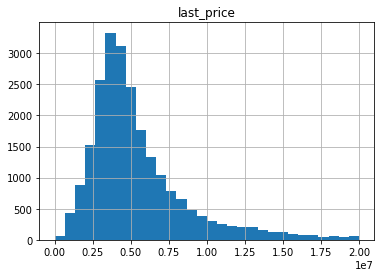

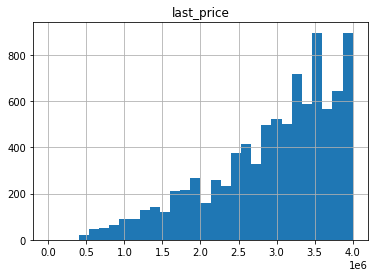

In [20]:
# показательные графики
data.hist('last_price', bins=30, range=(0,2e+07));
data.hist('last_price', bins=30, range=(0,4e+06));

data.drop(index=data.query('last_price < 1e+05').index,inplace=True)

*total_area* - рассмотрим аномально маленькие и аномально большие квартиры. По закону квартира не должна быть меньше 14 м

In [21]:
print('Квартир площадью менее 14 кв.м.:',data.query('total_area < 14')['total_area'].count()) 
print('Квартир площадью более 500 кв.м.:',data.query('total_area > 500')['total_area'].count())
data.drop(index=data.query('total_area < 14').index,inplace=True)
data.drop(index=data.query('total_area > 500').index,inplace=True)

Квартир площадью менее 14 кв.м.: 5
Квартир площадью более 500 кв.м.: 3


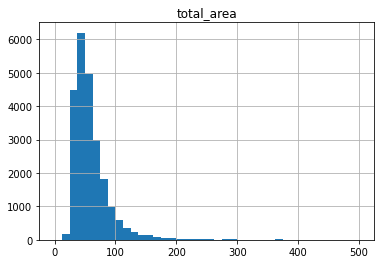

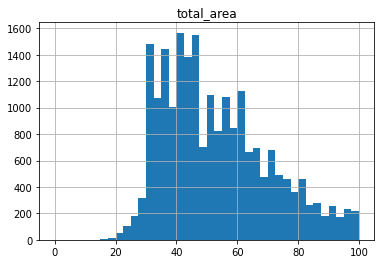

In [22]:
# показательные графики
data.hist('total_area', bins=40, range=(0,500));
data.hist('total_area', bins=40, range=(0,100));


*rooms* - исследования показывают нам, что есть квартиры без комнат. Рассмотрим варианты 

In [23]:
print('Квартиры без комнат:',data.query('rooms == 0')['rooms'].count())
print('Квартиры без комнат/студии:',data.query('rooms == 0 and studio')['rooms'].count()) 
print('Квартиры без комнат/апартаменты:',data.query('rooms == 0 and is_apartment')['rooms'].count()) 
print('Квартиры без комнат/свободная планировка:',data.query('rooms == 0 and open_plan')['rooms'].count())
print('Квартиры без комнат не апартаменты и не свободная планировка:',data.query('rooms == 0 and ~open_plan and ~studio')['rooms'].count())
# удалим квартиры с аномально большим кол-вом комнат
data.drop(index=data.query('rooms > 7').index,inplace=True)

Квартиры без комнат: 194
Квартиры без комнат/студии: 135
Квартиры без комнат/апартаменты: 188
Квартиры без комнат/свободная планировка: 59
Квартиры без комнат не апартаменты и не свободная планировка: 0


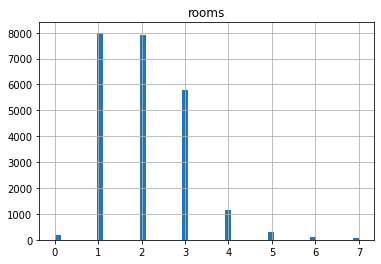

In [24]:
data.hist('rooms', bins=50, range=(0,7));



*ceiling_height* - высота потолков. По закону в жилых домах потолки должны быть от 2.5 - 4 метра. 

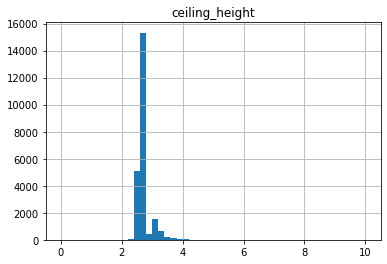

In [25]:
data.hist('ceiling_height', bins=50, range=(0,10));

In [26]:
print('Квартир с потолками больше 4 метров: ' + str(data.query('ceiling_height > 4')['ceiling_height'].count()) + ' шт.')
print('Квартир с потолками от 25м до 40м: ' + str(data.query('ceiling_height >= 25 and ceiling_height <= 40')['ceiling_height'].count()) + ' шт.')


Квартир с потолками больше 4 метров: 70 шт.
Квартир с потолками от 25м до 40м: 19 шт.


Предположим, что квартиры с высотой потолков 25-40м это строки в которых не указан разделяющий знак (2,5-4).
Для квартир с высотой потолков до 25 до 40 метров - делим на 10, получая 2.5 и 4 метра.
Следовательно квартиры с высотой потолков > 40м являются вбросами.
Удалим квартиры с высотой потолков меньше 2.5, от 4 до 25 и свыше 40 метров.


In [27]:
data.drop(index=data.query('ceiling_height < 2.5').index,inplace=True)
data.drop(index=data.query('ceiling_height > 4 and ceiling_height < 25').index,inplace=True)
data.update(data[(data['ceiling_height'] >= 25) & (data['ceiling_height'] <= 40)]['ceiling_height']/10)
data.drop(index=data.query('ceiling_height > 40').index,inplace=True)

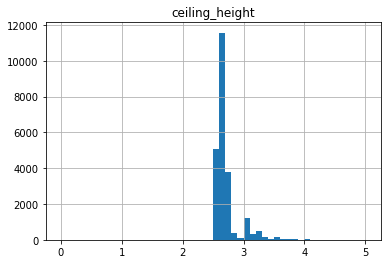

In [28]:
data.hist('ceiling_height', bins=50, range=(0,5));

*floors_total* - по графику видим, что основная часть домов лежит в диапазоне от 1 до 30 этажей.

Квартир в одноэтажных домах :  23
Квартир в 30+ этажных домах :  31


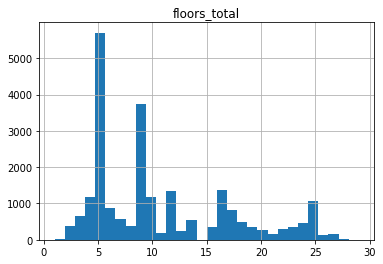

In [29]:
print('Квартир в одноэтажных домах : ',data.query('floors_total == 1')['floors_total'].count())
print('Квартир в 30+ этажных домах : ',data.query('floors_total > 30')['floors_total'].count())

data.drop(index=data.query('floors_total > 30').index,inplace=True)
data.hist('floors_total', bins=30);

*living_area* - большее количество квартир с площадью от 10 до 60 кв.м.
Отбросим значения с жилой площадью меньше 10кв.м.
Отбросим квартиры с площадью более 200 кв.м.
Так же важно проверить, чтобы жилая площадь квартиры не превышала ее общую площадь.

Жилая площадь меньше 10 кв.м.:  28
Жилая площадь больше общей:  0
Жилая площадь больше 200:  20


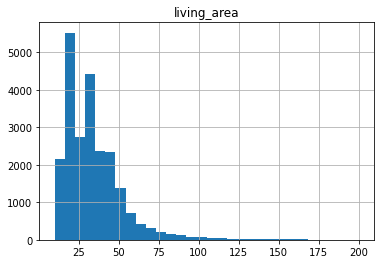

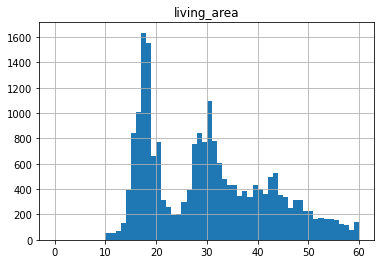

In [30]:
print('Жилая площадь меньше 10 кв.м.: ',data.query('living_area < 10')['living_area'].count())
print('Жилая площадь больше общей: ',data.query('living_area > total_area')['living_area'].count())
print('Жилая площадь больше 200: ',data.query('living_area > 200')['living_area'].count())

data.drop(index=data.query('living_area < 10').index,inplace=True)
data.drop(index=data.query('living_area > 200').index,inplace=True)

data.hist('living_area', bins=30);
data.hist('living_area', bins=60, range=(0,60));


*floor* - следует проверить, есть ли значения этажа больше этажности здания, а так же 0 этаж.


Этаж 0: 0
Этаж больше количества этажей:  0


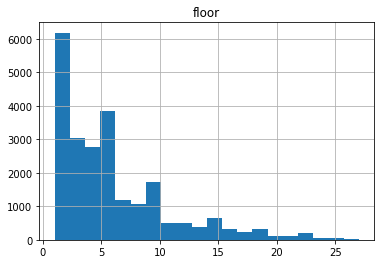

In [31]:
print('Этаж 0:',data.query('floor == 0')['floor'].count())
print('Этаж больше количества этажей: ',data.query('floor > floors_total')['floor'].count())
data.hist('floor',bins=20);

*kitchen_area* - площадь кухни. Здесь есть квартира с площадью кухни меньше 1 кв. метра - аномалия. Кухонь с площадью более 50 кв.м. довольно мало. Следовательно удалим строки с кухнями менее 2 кв.м. и больше 50кв.м.

Площадь кухни меньше 2 кв.м.:  1
Площадь кухни больше 50 кв.м.:  36
Площадь кухни больше общей:  0


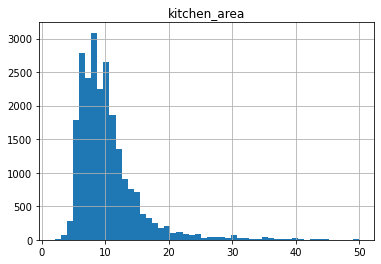

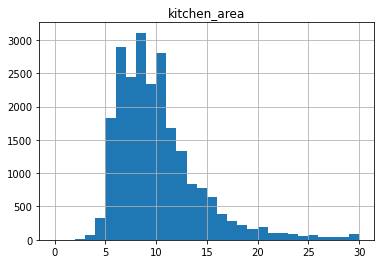

In [32]:
print('Площадь кухни меньше 2 кв.м.: ',data.query('kitchen_area < 2')['living_area'].count())
print('Площадь кухни больше 50 кв.м.: ',data.query('kitchen_area > 50')['living_area'].count())
print('Площадь кухни больше общей: ',data.query('kitchen_area > total_area')['living_area'].count())

data.drop(index=data.query('kitchen_area < 2').index,inplace=True)
data.drop(index=data.query('kitchen_area > 50').index,inplace=True)

data.hist('kitchen_area', bins=50);
data.hist('kitchen_area', bins=30, range=(0,30));

*balcony* - по графику аномалий не выявлено.

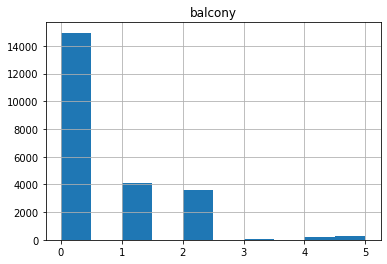

In [33]:
data.hist('balcony', bins=10);

*days_exposition* - кол-во дней с момента размещения обьявления. По гистограмме видим что в целом вбросов и аномалий нет. Удалим обьявления которым больше 3 лет.

Объявлению больше 3 лет :  163


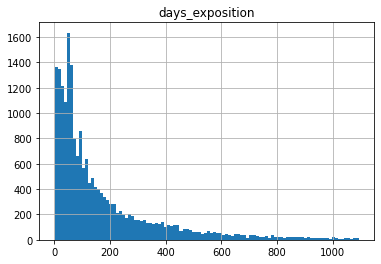

In [34]:
print('Объявлению больше 3 лет : ',data.query('days_exposition > 365*3')['days_exposition'].count())

data.drop(index=data.query('days_exposition > 365*3').index,inplace=True)

data.hist('days_exposition', bins=100);


Данные в следующих столбцах собраны автоматически. Глядя на гистограммы аномалий не выявлено.
- airports_nearest
- city_centers_nearest
- parks_around_3000
- parks_nearest
- ponds_around_3000
- ponds_nearest


In [35]:
# сброс индексации
data.reset_index(drop=True,inplace=True)

In [36]:

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23089 entries, 0 to 23088
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23089 non-null  int64         
 1   last_price            23089 non-null  int64         
 2   total_area            23089 non-null  float64       
 3   first_day_exposition  23089 non-null  datetime64[ns]
 4   rooms                 23089 non-null  int64         
 5   ceiling_height        23089 non-null  float64       
 6   floors_total          23089 non-null  Int8          
 7   living_area           23089 non-null  float64       
 8   floor                 23089 non-null  int64         
 9   is_apartment          23089 non-null  object        
 10  studio                23089 non-null  bool          
 11  open_plan             23089 non-null  bool          
 12  kitchen_area          23089 non-null  float64       
 13  balcony         

*Вывод*: В процессе предобработки данных пропуски значений были заполнены в зависимости от ситуации:
- медианой по группам значений либо общей медианой по всем значениям,
- там, где логически это возможно – конкретными значениями ( например False, 0)
- В случаях , когда заполнение невозможно, строки были удалены (отсутствие наименования населенного пункта в locality_name, количество этажей в доме , floors_total)

Среди возможных причин пропусков можно указать:
- незаполнение поля клиентом в случае отсутствия информации
- сбой при выгрузке данных.
- разные форматы данных из разных источников


### Посчитайте и добавьте в таблицу новые столбцы

In [37]:
# цена квадратного метра
data['cost_per_metr'] = data['last_price'] / data['total_area']

#добавление столбца с днем недели публикации объявления
data['dayofweek'] = data['first_day_exposition'].dt.weekday

#добавление столбца с месяцем публикации объявления
data['month'] = data['first_day_exposition'].dt.month

#добавление столбца с годом публикации
data['year'] = data['first_day_exposition'].dt.year


In [38]:
# тип этажа квартиры (значения — «первый», «последний», «другой»)
def floors_category(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'

#применяем метод apply и функцию floors_category к созданному столбцу floor_group:
data['floor_group'] = data.apply(floors_category, axis=1)  

In [39]:
# расстояние в км до центра города
data['city_centers_nearest_km'] = round(data['city_centers_nearest'] / 1000)


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23089 entries, 0 to 23088
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   total_images             23089 non-null  int64         
 1   last_price               23089 non-null  int64         
 2   total_area               23089 non-null  float64       
 3   first_day_exposition     23089 non-null  datetime64[ns]
 4   rooms                    23089 non-null  int64         
 5   ceiling_height           23089 non-null  float64       
 6   floors_total             23089 non-null  Int8          
 7   living_area              23089 non-null  float64       
 8   floor                    23089 non-null  int64         
 9   is_apartment             23089 non-null  object        
 10  studio                   23089 non-null  bool          
 11  open_plan                23089 non-null  bool          
 12  kitchen_area             23089 n

### Проведите исследовательский анализ данных

1. ***Изучение основных параметров***

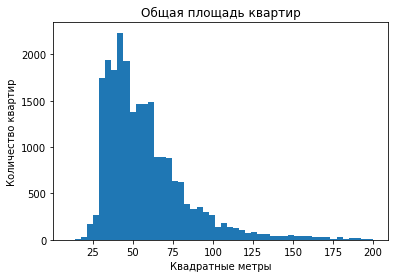

Наибольшие по площади варианты:
14612    413.5
4912     380.0
19459    365.0
20293    342.0
15778    336.0
14221    327.2
10808    320.0
7462     315.0
7730     312.0
9324     312.0
Name: total_area, dtype: float64


In [41]:
# Общая площадь
plt.hist(data['total_area'], bins=50, range=(10,200))
plt.title('Общая площадь квартир')
plt.xlabel('Квадратные метры')
plt.ylabel('Количество квартир')
plt.show()
print('Наибольшие по площади варианты:')
print(data['total_area'].sort_values(ascending=False).head(10))


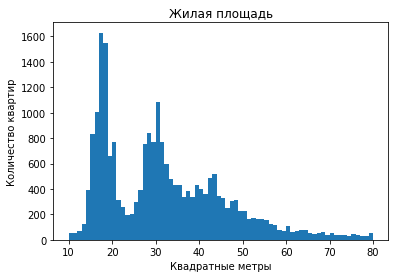

Наибольшие по жилой площади варианты:
9988     200.0
22316    200.0
4912     198.0
7730     194.0
4089     193.5
7491     193.0
10808    190.0
20293    187.0
8522     184.9
2956     184.0
Name: living_area, dtype: float64


In [42]:
# Жилая площадь
plt.hist(data['living_area'], bins=70, range=(10,80))
plt.title('Жилая площадь')
plt.xlabel('Квадратные метры')
plt.ylabel('Количество квартир')
plt.show()
print('Наибольшие по жилой площади варианты:')
print(data['living_area'].sort_values(ascending=False).head(10))


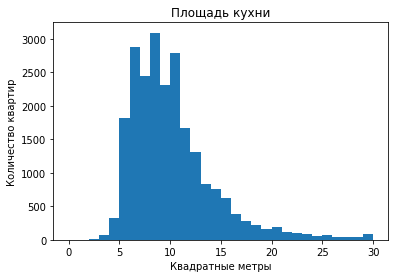

Наибольшие по площади кухни варианты:
9754     50.0
51       50.0
496      50.0
635      50.0
4912     50.0
2286     50.0
18784    50.0
5003     50.0
20790    49.4
256      49.2
Name: kitchen_area, dtype: float64


In [43]:
# площадь кухни
plt.hist(data['kitchen_area'], bins=30, range=(0,30))
plt.title('Площадь кухни')
plt.xlabel('Квадратные метры')
plt.ylabel('Количество квартир')
plt.show()
print('Наибольшие по площади кухни варианты:')
print(data['kitchen_area'].sort_values(ascending=False).head(10))

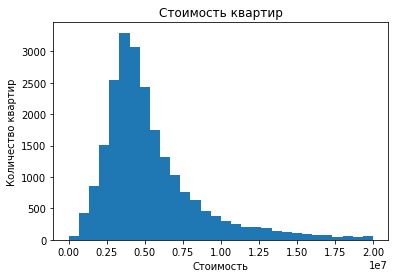

Наибольшие по цене варианты:
5492     99000000
16179    98000000
11043    95000000
494      90000000
5396     87000000
11740    86738800
11140    85000000
10101    83820000
6293     82000000
6291     82000000
Name: last_price, dtype: int64


In [44]:
# цена обьекта
plt.hist(data['last_price'], bins=30, range=(0,20000000))
plt.title('Стоимость квартир')
plt.xlabel('Стоимость')
plt.ylabel('Количество квартир')
plt.show()
print('Наибольшие по цене варианты:')
print(data['last_price'].sort_values(ascending=False).head(10))

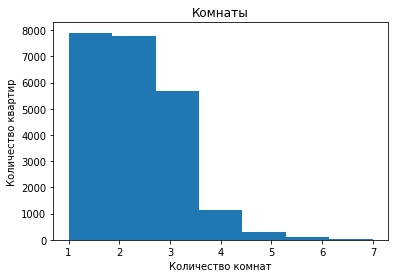

Наибольшие по числу комнат варианты:
825      7
5314     7
13182    7
21692    7
14233    7
13429    7
5571     7
21139    7
3273     7
2391     7
Name: rooms, dtype: int64


In [45]:
# количество комнат
plt.hist(data['rooms'], bins=7, range=(1,7))
plt.title('Комнаты')
plt.xlabel('Количество комнат')
plt.ylabel('Количество квартир')
plt.show()
print('Наибольшие по числу комнат варианты:')
print(data['rooms'].sort_values(ascending=False).head(10))

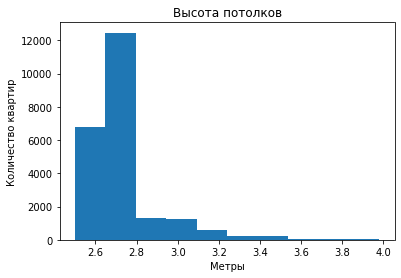

Наибольшие по высоте потолков варианты:
11467    4.0
19124    4.0
16767    4.0
13539    4.0
13647    4.0
18344    4.0
22371    4.0
7493     4.0
176      4.0
9684     4.0
Name: ceiling_height, dtype: float64


In [46]:
# высота потолков
plt.hist(data.query('(ceiling_height > 2) & (ceiling_height < 4)')['ceiling_height'], bins=10)
plt.title('Высота потолков')
plt.xlabel('Метры')
plt.ylabel('Количество квартир')
plt.show()
print('Наибольшие по высоте потолков варианты:')
print(data['ceiling_height'].sort_values(ascending=False).head(10))

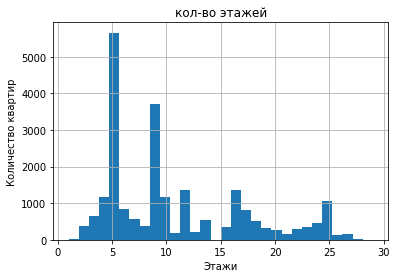

In [47]:
# общее кол-во этажей
data.hist('floors_total', bins= 30);
plt.title('кол-во этажей')
plt.xlabel('Этажи')
plt.ylabel('Количество квартир')
plt.show()

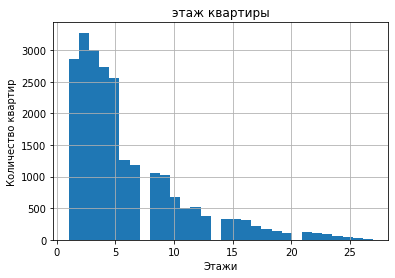

In [48]:
# этаж квартиры
data.hist('floor', bins = 30);
plt.title('этаж квартиры')
plt.xlabel('Этажи')
plt.ylabel('Количество квартир')
plt.show()


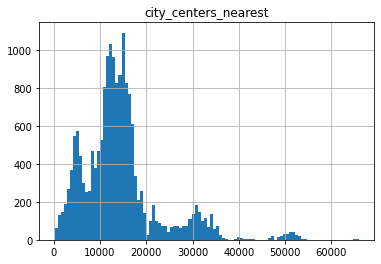

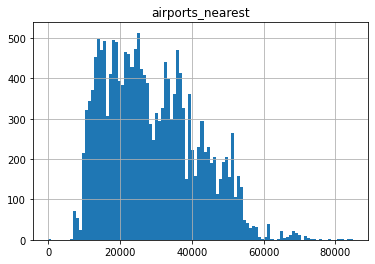

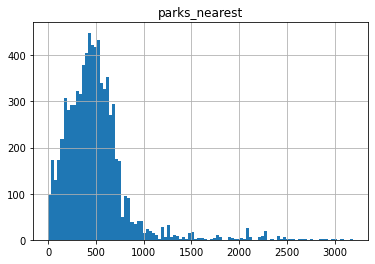

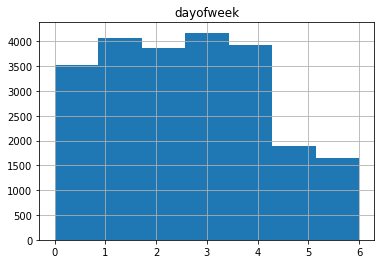

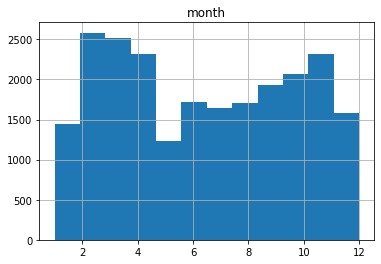

In [49]:
# расстояние до центра города в метрах;
data.hist('city_centers_nearest', bins=100);
# расстояние до ближайшего аэропорта;
data.hist('airports_nearest', bins=100);
# расстояние до ближайшего парка;
data.hist('parks_nearest', bins=100);
# день и месяц публикации;
data.hist('dayofweek', bins=7);
data.hist('month', bins=12);

***Вывод***

- *Площадь*:
Большинство квартир - менее 100 квадратных метров, больше площадь практически не встречается. В подборке есть несколько очень больших  вариантов с площадью более 200 квадратных метров.
- *Площадь кухни*:  Самые распространённые кухни - от 5 до 15 метров. Больше 20 метров кухни практически не встречаются. Больше 30 - единичные случаи.
- *Жилая площадь*: Самые распространённые варианты с жилой площадью от 10 до 50 метров. После 80 метров встречаются единичные случаи. Два пика графика вызваны, вероятно, тем, что это жилые площади для 1-комнатной, затем для 2-комнатной и после этого для 3-комнатной квартиры.
- *Цена обьекта*: В основном стоимость квартир - порядка 5 миллионов. Больше 20 миллионов вариантов мало и они выглядят очень странно и некоторые - на порядок дороже.
- *кол-во комнат*: В основном квартиры состоят из 1, 2 и 3 комнат. Есть небольшая доля 4-комнатных квартир. Варианты, где больше 7 комнат выглядят неправдоподобно. Возможно, это отдельный дом.
- *Высота потолков*: Большинство вариантов имеют высоту потолков от 2,5 до 3 метров. Больше 4 метров высота потолков выглядит подозрительно.
- расстояние до центра города в метрах: Здесь наблюдаем два пика, один маленький, 5км и другой побльшой от 10 км. до 15 км. Так же есть совсем небольшие всплески на 30 км. и 50 км.
- расстояние до ближайшего аэропорта: Здесь видим довольно "шумный" график. Но это вполне нормально.
- расстояние до ближайшего парка: Судя по графику больше всего квартир с парками на расстоянии до 750м.
- день и месяц публикации объявления: Видим провал в публикации объявлений в субботу и воскресенье, что логично. Так же видим что с февраля по апрель наблюдалосась повышенная активность. Так же был плавный рост активности с июля по ноябрь. Провалы в декабре, январе и мае.


1. ***Изучение времени продажи квартиры***

Среднее время продажи квартиры в днях: 171
Медианное время продажи квартиры в днях: 93


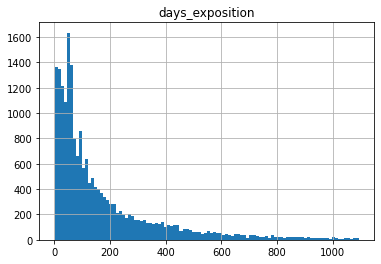

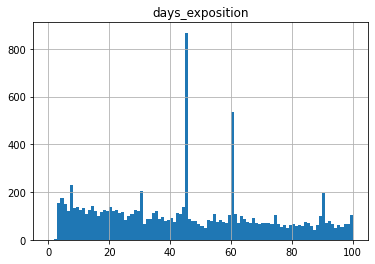

In [50]:
data.hist('days_exposition', bins=100);
data.hist('days_exposition', bins=100, range = (0,100));
print(f'Среднее время продажи квартиры в днях:',int(data['days_exposition'].mean()))
print('Медианное время продажи квартиры в днях:',int(data['days_exposition'].median()))

*Вывод* - Исходя из полученных результатов, среднее время продажи квартиры составляет 171 день . В то время как медиана - 93 дня, в два раза меньше. Так происходит потому что у нас есть очень большое количество квартир, которые продавались годами.
Я бы предложил считать быстрыми продажи до 93 дней, а долгими - свыше 171 дня. Предполагаю, что выбросы - платные обьявления с истекшим сроком публикации.

3.***Факторы которые больше всего влияют на общую (полную) стоимость объекта***

In [51]:
factor_cost = ['total_area',
                  'living_area',
                  'kitchen_area',
                  'rooms',
                  'dayofweek',
                  'month',
                  'year']

for entry in factor_cost:
    correlation = data['last_price'].corr(data[entry])
    print(f'Корреляция между last_price и {entry} составляет: {correlation:0.2%}')

Корреляция между last_price и total_area составляет: 75.17%
Корреляция между last_price и living_area составляет: 66.85%
Корреляция между last_price и kitchen_area составляет: 57.97%
Корреляция между last_price и rooms составляет: 46.03%
Корреляция между last_price и dayofweek составляет: -0.32%
Корреляция между last_price и month составляет: 0.64%
Корреляция между last_price и year составляет: -4.08%


Построим наглядные графики для каждой категории.

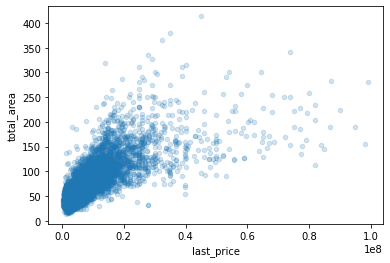

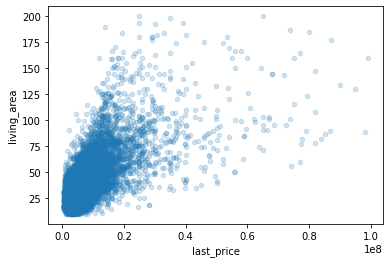

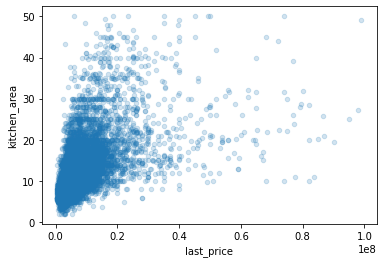

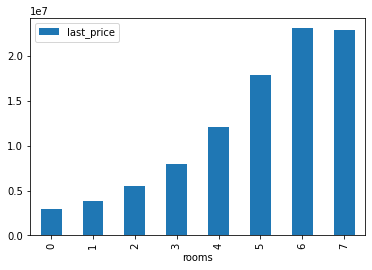

In [52]:
data.plot(x='last_price', y='total_area', kind='scatter', alpha=0.2)
data.plot(x='last_price', y='living_area', kind='scatter', alpha=0.2)
data.plot(x='last_price', y='kitchen_area', kind='scatter', alpha=0.2)
data.pivot_table(index='rooms',values='last_price').plot(y='last_price', kind='bar');


***Вывод***: 
Цена прямо пропорционально зависит от:
общей площади;
жилой площади;
площади кухни;
количества комнат.
Цена практически на зависит от даты размещения.

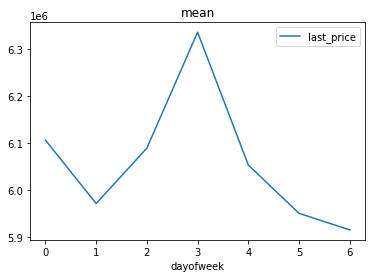

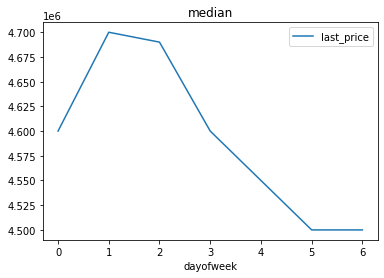

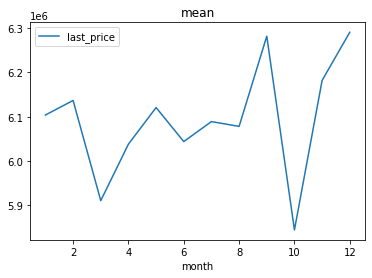

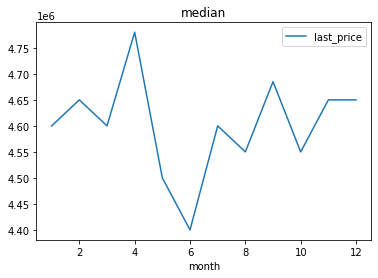

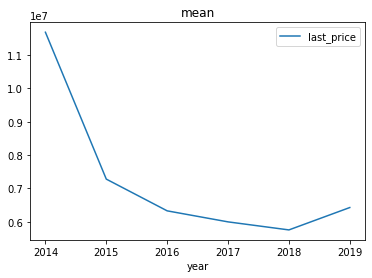

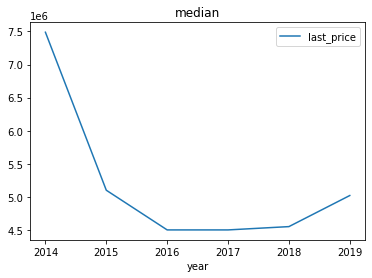

In [53]:
data.pivot_table(index='dayofweek',values='last_price',aggfunc='mean').plot(y='last_price', kind='line', title='mean');
data.pivot_table(index='dayofweek',values='last_price',aggfunc='median').plot(y='last_price', kind='line', title='median');

data.pivot_table(index='month',values='last_price',aggfunc='mean').plot(y='last_price', kind='line', title='mean');
data.pivot_table(index='month',values='last_price',aggfunc='median').plot(y='last_price', kind='line', title='median');

data.pivot_table(index='year',values='last_price',aggfunc='mean').plot(y='last_price', kind='line', title='mean');
data.pivot_table(index='year',values='last_price',aggfunc='median').plot(y='last_price', kind='line', title='median');

<AxesSubplot:xlabel='last_price', ylabel='floor_group'>

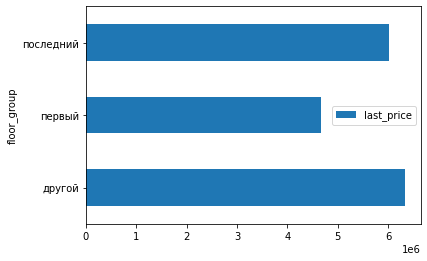

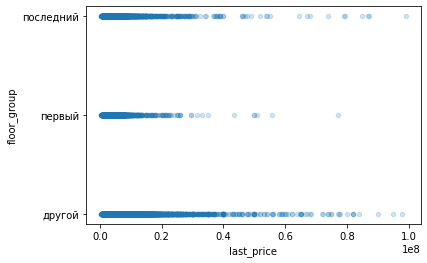

In [54]:
data.pivot_table(index='floor_group',values='last_price').plot(y='last_price', kind='barh');

data.plot(x='last_price', y='floor_group', kind='scatter', alpha=0.2)

4.***Cредняя цена одного квадратного метра в топ-10 населенных пунктах***

<AxesSubplot:ylabel='locality_name'>

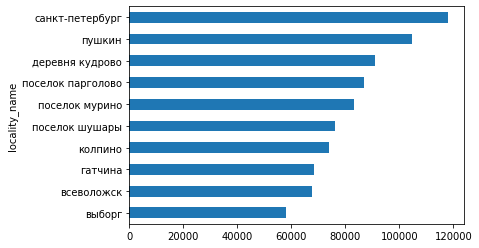

In [55]:
top_10 = data.pivot_table(index='locality_name', values=['last_price','total_area'] ,aggfunc=['sum','count'])
top_10.columns=['last_price_sum','total_area_sum','last_price_count','total_area_count']
top_10.pop('total_area_count')
top_10.sort_values(by=['last_price_count'],ascending=False, inplace=True)
top_10 = top_10.iloc[:10]
top_10['price_per_sq_m'] = top_10['last_price_sum']/top_10['total_area_sum']
top_10.sort_values(by=['price_per_sq_m'],ascending=True, inplace=True)
top_10['price_per_sq_m'].plot(kind='barh')

In [56]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,cost_per_metr,dayofweek,month,year,floor_group,city_centers_nearest_km
0,20,13000000,108.0,2019-03-07,3,2.70,16,51.000000,8,False,...,482.0,2,755.0,NaN,120370.370370,3,3,2019,другой,16.0
1,7,3350000,40.4,2018-12-04,1,2.65,11,18.600000,1,False,...,NaN,0,NaN,81.0,82920.792079,1,12,2018,первый,19.0
2,10,5196000,56.0,2015-08-20,2,2.65,5,34.300000,4,False,...,90.0,2,574.0,558.0,92785.714286,3,8,2015,другой,14.0
3,0,64900000,159.0,2015-07-24,3,2.65,14,90.785766,9,False,...,84.0,3,234.0,424.0,408176.100629,4,7,2015,другой,7.0
4,2,10000000,100.0,2018-06-19,2,3.03,14,32.000000,13,False,...,112.0,1,48.0,121.0,100000.000000,1,6,2018,другой,8.0


*Выыод* - Самая дорогая недвижимость находится в Санкт-Петербурге.В ТОП-10 входят ближайшие к Санкт-Петербургу населенные пункты.

5.***Расстояние до центра***

<AxesSubplot:xlabel='city_centers_nearest_km'>

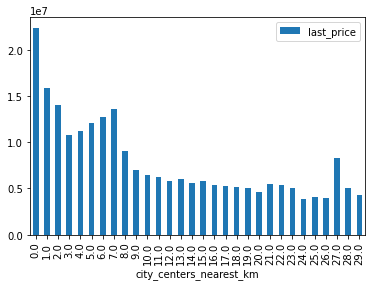

In [57]:
(
    data[data['locality_name']=='санкт-петербург']
    .pivot_table(
        index='city_centers_nearest_km',
        values='last_price',
        aggfunc='mean')
    .plot(kind='bar')
)

*Вывод*: Мы наглядно видим, что чем ближе недвижимость находится к центру - тем она дороже. В самом центре - сильно дороже. Некоторые выбросы как например на 27км могут быть связаны с премиальным районом.

### Общий вывод

Для анализа были представленны данные о квартирах выставленных на продажу, часть из которых были вписаны пользователем, часть полученна автоматически. 

На этапе предобработки данных были выявлены явные и неявные недочеты в данных. Они были исправлены. Скорее всего фактором таких ошибок служил человеческий фактор, люди ошибались при заполнении заявлений.

Так же для анализа были добавленны дополнительные столбцы в датасет: цена одного квадратного метра; месяц публикации объявления;год публикации объявления;тип этажа квартиры ;расстояние до центра города в километрах; 

- Срок продажи квартиры 

Чаще всего квартиру продают за 93 дней. Если меньше 93 дней, то это быстро, если дольше 171 дня - это долго. Существуют квартиры которые продавались годами.

- Факторы, влияющие на стоимость 

Цена прямо пропорционально зависит от: общей площади; жилой площади; площади кухни; количества комнат. Цена практически на зависит от даты размещения.

- Стоимость квадратного метра в топ-10 населённых пунктов 

Самая дорогая недвижимость находится в Санкт-Петербурге.В ТОП-10 входят ближайшие к Санкт-Петербургу населенные пункты.

- Факторы, влияющие на стоимость в центре Санкт-Петербурга 

Мы наглядно видим, что чем ближе недвижимость находится к центру - тем она дороже. В самом центре - сильно дороже. Некоторые выбросы как например на 27км могут быть связаны с премиальным районом.

Иследование показало, что на рынке недвижимости представлено жилье с большим разбросом площади и цены. Цена 1 кв.м. зависит от удаленности от центра, этажа  и количества комнат. Так же имеет место быть сезонность цен: в целом после окончания года к марту цена начинает расти, а летом падает. Это связано с экономикой: спад, как правило прослеживается в феврале и летом.






**Чек-лист готовности проекта**




- [x]  открыт файл
- [x]  файлы изучены (выведены первые строки, метод `info()`, гистограммы и т.д.)
- [x]  определены пропущенные значения
- [x]  заполнены пропущенные значения там, где это возможно
- [x]  есть пояснение, какие пропущенные значения обнаружены
- [x]  изменены типы данных
- [x]  есть пояснение, в каких столбцах изменены типы и почему
- [x]  устранены неявные дубликаты в названиях населённых пунктов
- [x]  устранены редкие и выбивающиеся значения (аномалии) во всех столбцах
- [x]  посчитано и добавлено в таблицу: цена одного квадратного мета
- [x]  посчитано и добавлено в таблицу: день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
- [x]  посчитано и добавлено в таблицу: месяц публикации объявления
- [x]  посчитано и добавлено в таблицу: год публикации объявления
- [x]  посчитано и добавлено в таблицу: тип этажа квартиры (значения — «первый», «последний», «другой»)
- [x]  посчитано и добавлено в таблицу: расстояние в км до центра города
- [x]  изучены и описаны следующие параметры:
        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления
- [x]  построены гистограммы для каждого параметра
- [x]  выполнено задание: "Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление.
    - Постройте гистограмму.
    - Посчитайте среднее и медиану.
    - В ячейке типа markdown опишите, сколько обычно занимает продажа. Какие продажи можно считать быстрыми, а какие — необычно долгими?"
- [x]  выполнено задание: "Какие факторы больше всего влияют на общую (полную) стоимость объекта? Постройте графики, которые покажут зависимость цены от указанных ниже параметров. Для подготовки данных перед визуализацией вы можете использовать сводные таблицы."
        - общей площади;
        - жилой площади;
        - площади кухни;
        - количество комнат;
        - типа этажа, на котором расположена квартира (первый, последний, другой);
        - даты размещения (день недели, месяц, год);
- [x]  выполнено задание: "Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце `locality_name`."
- [x]  выполнено задание: "Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города."
- [x]  в каждом этапе есть промежуточные выводы
- [x]  есть общий вывод